Intelligent Fraud Detection System

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    f1_score
)


In [ ]:
# 1. Load Dataset

data = pd.read_csv("/content/drive/MyDrive/Datasets/creditcard.csv")

print("Dataset Shape:", data.shape)
print("\nClass Distribution:")
print(data["Class"].value_counts())


Dataset Shape: (284807, 31)

Class Distribution:
Class
0    284315
1       492
Name: count, dtype: int64


In [ ]:
# 2. Feature Scaling


scaler = StandardScaler()
data["Amount"] = scaler.fit_transform(data["Amount"].values.reshape(-1, 1))
data["Time"] = scaler.fit_transform(data["Time"].values.reshape(-1, 1))

In [ ]:
# 3. Train-Test Split

X = data.drop("Class", axis=1)
y = data["Class"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [ ]:
# 4. Define Models

models = {
    "Logistic Regression": LogisticRegression(
        class_weight="balanced",
        max_iter=1000,
        n_jobs=-1
    ),

    "Random Forest": RandomForestClassifier(
        n_estimators=50,
        class_weight="balanced",
        random_state=42,
        n_jobs=-1
    ),

    "Gradient Boosting": HistGradientBoostingClassifier(
        max_iter=100,                 # number of trees
        learning_rate=0.1,
        max_depth=6,
        class_weight="balanced",
        random_state=42
    )
}

results = {}
fraud_f1_scores = {}


Training Logistic Regression...

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.06      0.92      0.11        98

    accuracy                           0.98     56962
   macro avg       0.53      0.95      0.55     56962
weighted avg       1.00      0.98      0.99     56962

Logistic Regression ROC-AUC: 0.9722
Logistic Regression Fraud F1 Score: 0.1141


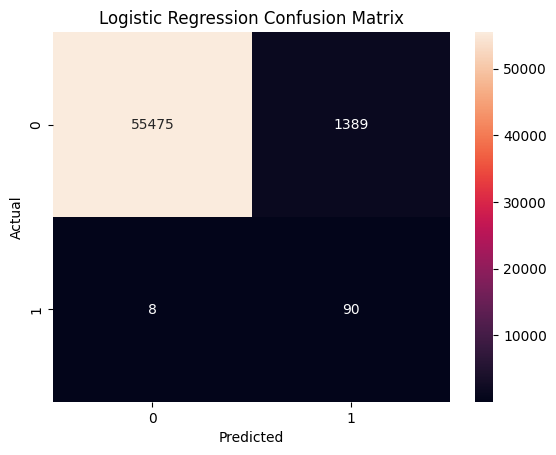

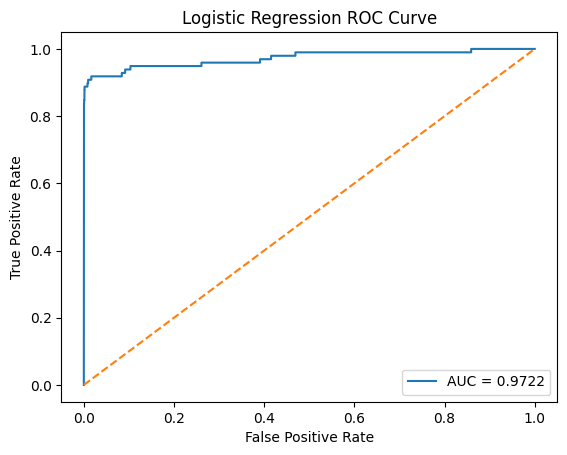


Training Random Forest...

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.96      0.73      0.83        98

    accuracy                           1.00     56962
   macro avg       0.98      0.87      0.92     56962
weighted avg       1.00      1.00      1.00     56962

Random Forest ROC-AUC: 0.9534
Random Forest Fraud F1 Score: 0.8324


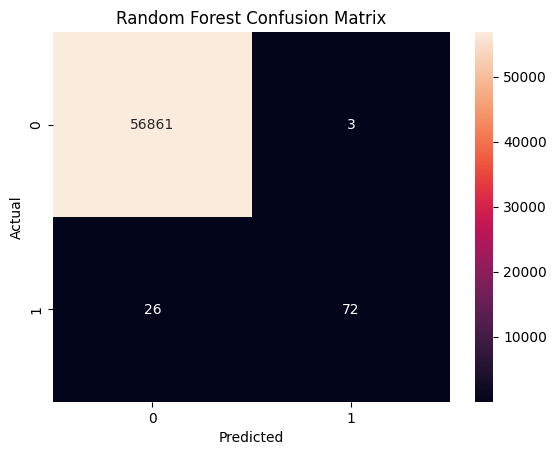

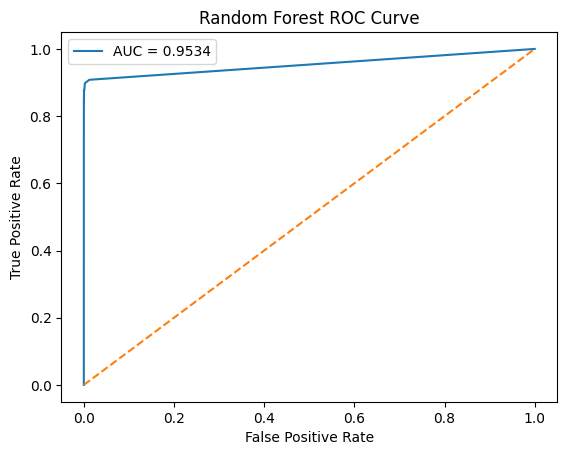


Training Gradient Boosting...

Gradient Boosting Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.29      0.86      0.43        98

    accuracy                           1.00     56962
   macro avg       0.64      0.93      0.72     56962
weighted avg       1.00      1.00      1.00     56962

Gradient Boosting ROC-AUC: 0.9755
Gradient Boosting Fraud F1 Score: 0.4330


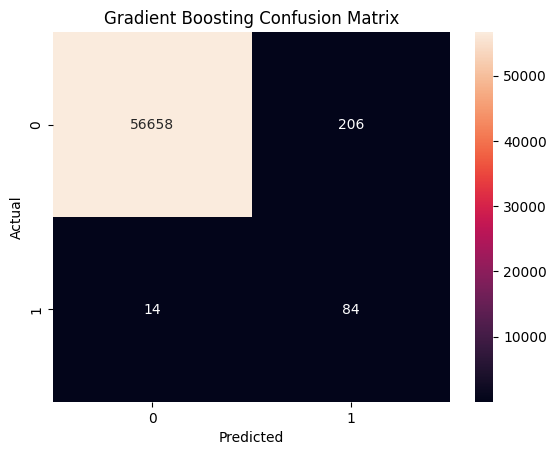

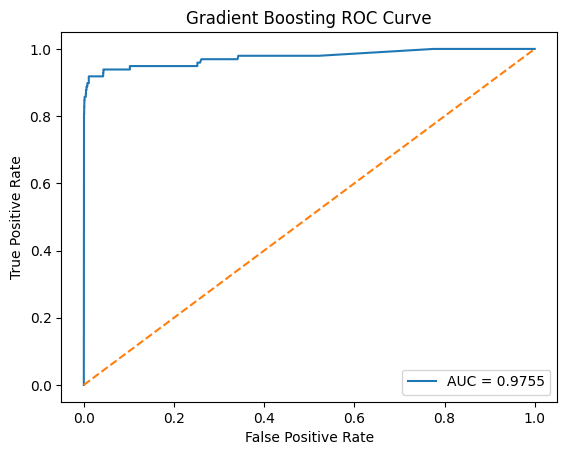

In [ ]:
# 5. Training and Evaluation

for name, model in models.items():
    print(f"\nTraining {name}...")

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    print(f"\n{name} Classification Report:")
    print(classification_report(y_test, y_pred))

    roc_auc = roc_auc_score(y_test, y_prob)
    fraud_f1 = f1_score(y_test, y_pred, pos_label=1)

    print(f"{name} ROC-AUC: {roc_auc:.4f}")
    print(f"{name} Fraud F1 Score: {fraud_f1:.4f}")

    results[name] = roc_auc
    fraud_f1_scores[name] = fraud_f1

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure()
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.title(f"{name} ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()

In [ ]:
# 6. Select Best Model (Based on Fraud F1)

best_model_name = max(fraud_f1_scores, key=fraud_f1_scores.get)

print("\nModel Comparison (ROC-AUC Scores):")
for k, v in results.items():
    print(f"{k}: {v:.4f}")

print(f"\nBest Performing Model (Based on Fraud F1): {best_model_name}")

best_model = models[best_model_name]



Model Comparison (ROC-AUC Scores):
Logistic Regression: 0.9722
Random Forest: 0.9534
Gradient Boosting: 0.9755

Best Performing Model (Based on Fraud F1): Random Forest


In [ ]:
# 7. Stratified Cross Validation

print("\nPerforming Stratified Cross Validation...")

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

cv_scores = cross_val_score(
    best_model,
    X_train,
    y_train,
    cv=skf,
    scoring="roc_auc",
    n_jobs=-1
)

print("Cross-Validation ROC-AUC Scores:", cv_scores)
print("Mean ROC-AUC:", cv_scores.mean())


Performing Stratified Cross Validation...
Cross-Validation ROC-AUC Scores: [0.93825903 0.93789208 0.95712924]
Mean ROC-AUC: 0.944426786031073


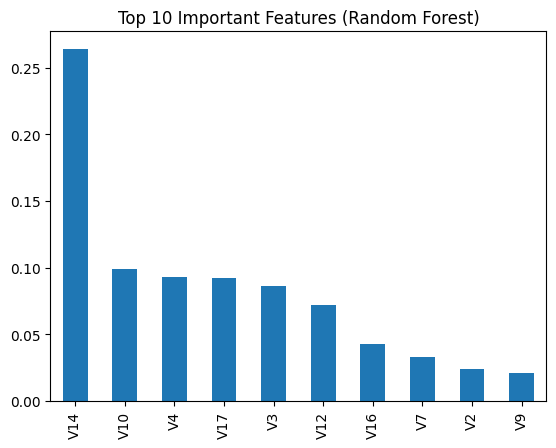


Fraud Detection System Completed Successfully.


In [ ]:
# 8. Feature Importance

if best_model_name == "Random Forest":
    importances = best_model.feature_importances_
    feature_importance = pd.Series(importances, index=X.columns)
    top_features = feature_importance.sort_values(ascending=False).head(10)

    plt.figure()
    top_features.plot(kind="bar")
    plt.title("Top 10 Important Features (Random Forest)")
    plt.show()

print("\nFraud Detection System Completed Successfully.")